In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from mlxtend.preprocessing import TransactionEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import datetime

In [5]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
sns.set(style="whitegrid")

In [7]:
data = pd.read_csv('C:/Users/ZTall/OneDrive/Documents/Groceries_dataset.csv') #First dataset

In [8]:
data

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk
...,...,...,...
38760,4471,08-10-2014,sliced cheese
38761,2022,23-02-2014,candy
38762,1097,16-04-2014,cake bar
38763,1510,03-12-2014,fruit/vegetable juice


In [9]:
print("Column Names:", data.columns)
print(data.head())

Column Names: Index(['Member_number', 'Date', 'itemDescription'], dtype='object')
   Member_number        Date   itemDescription
0           1808  21-07-2015    tropical fruit
1           2552  05-01-2015        whole milk
2           2300  19-09-2015         pip fruit
3           1187  12-12-2015  other vegetables
4           3037  01-02-2015        whole milk


In [11]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB


In [12]:
data.isnull().sum().sort_values(ascending=False)

Member_number      0
Date               0
itemDescription    0
dtype: int64

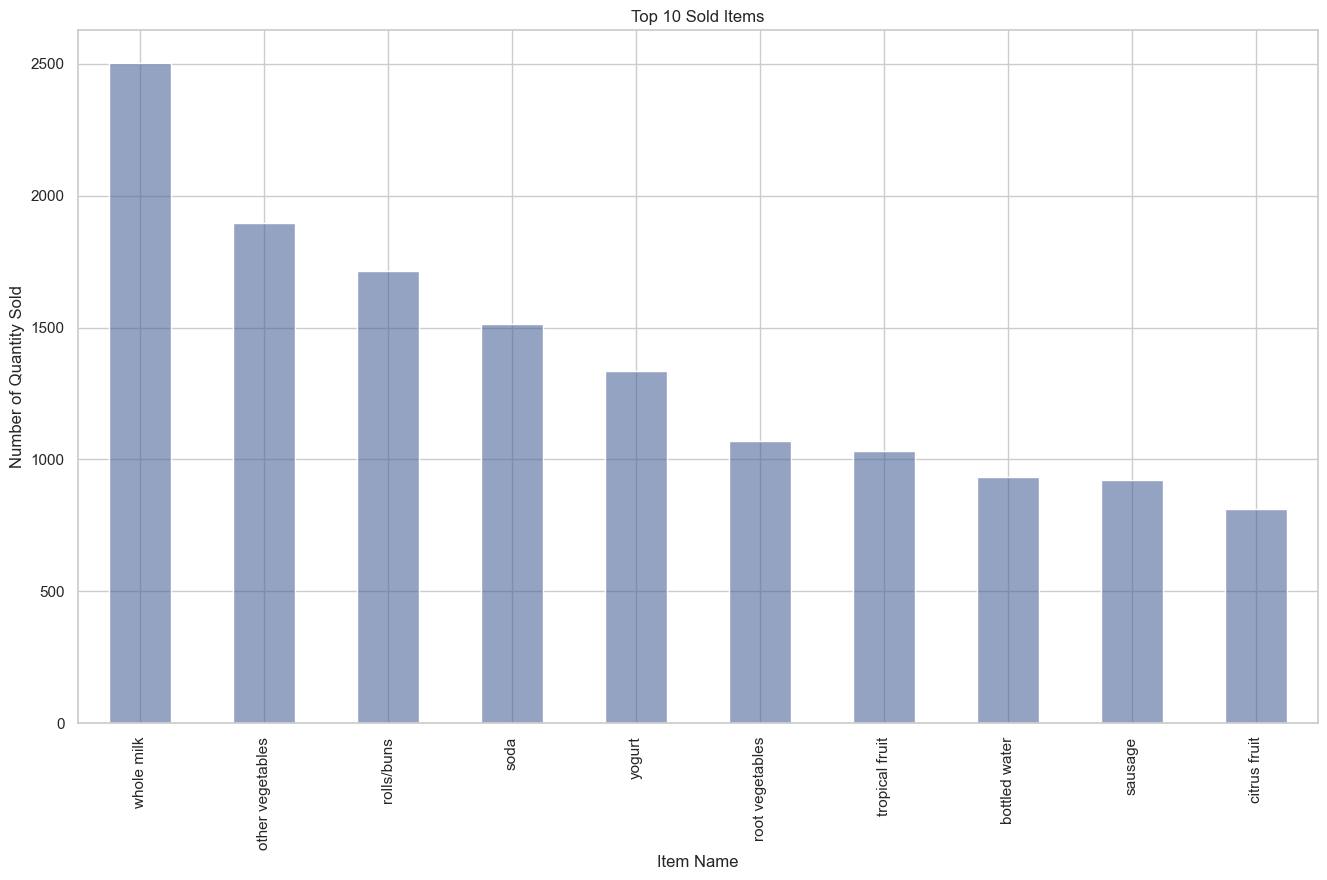

In [13]:
import matplotlib.pyplot as plt

item_distr = data["itemDescription"].value_counts().head(10)
# Plot the top 10 items sold
plt.figure(figsize=(16, 9))
item_distr.plot(kind='bar', color=(0.3, 0.4, 0.6, 0.6))

plt.title("Top 10 Sold Items")
plt.xlabel("Item Name")
plt.ylabel("Number of Quantity Sold")

plt.show()
plt.show()

In [15]:
cust_level = data[["Member_number", "itemDescription"]].sort_values(by = "Member_number", ascending = False) ## Selecting only required variables for modelling
cust_level['itemDescription'] = cust_level['itemDescription'].str.strip() # Removing white spaces if any
cust_level

,Member_number,itemDescription
3578,5000,soda
34885,5000,semi-finished bread
11728,5000,fruit/vegetable juice
9340,5000,bottled beer
19727,5000,root vegetables
...,...,...
13331,1000,whole milk
17778,1000,pickled vegetables
6388,1000,sausage
20992,1000,semi-finished bread


In [16]:
# Group the data by 'Member_number' (which represents transactions)
transactions = data.groupby('Member_number')['itemDescription'].apply(list)

In [17]:
# Transform the transaction data for analysis using TransactionEncoder
te = TransactionEncoder()
te_data = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_data, columns=te.columns_)

In [ ]:
Apriori is an algorithm for frequent itemset mining and association rule learning over relational databases. It proceeds by identifying the frequent individual items in the database and extending them to larger and larger item sets as long as those item sets appear sufficiently often in the database. The frequent itemsets determined by Apriori can be used to determine association rules which highlight general trends in the database: this has applications in domains such as market basket analysis.

In [18]:
# Generate frequent itemsets using Apriori
frequent_itemsets_apriori = apriori(df, min_support=0.01, use_colnames=True)

In [41]:
# Generate association rules from the frequent itemsets
rules_apriori = association_rules(frequent_itemsets_apriori,'Member_number',metric="confidence", min_threshold=0.5)

# Display the generated rules
print("Apriori Association Rules:")
print(rules_apriori[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

Apriori Association Rules:
                                            antecedents         consequents  \
0                                            (UHT-milk)        (whole milk)   
1                                                (beef)        (whole milk)   
2                                        (bottled beer)        (whole milk)   
3                                       (bottled water)        (whole milk)   
4                                         (brown bread)        (whole milk)   
...                                                 ...                 ...   
1112  (other vegetables, rolls/buns, yogurt, shoppin...        (whole milk)   
1113  (other vegetables, shopping bags, yogurt, whol...        (rolls/buns)   
1114    (yogurt, rolls/buns, shopping bags, whole milk)  (other vegetables)   
1115       (yogurt, soda, rolls/buns, other vegetables)        (whole milk)   
1116             (yogurt, soda, rolls/buns, whole milk)  (other vegetables)   

       support  confiden

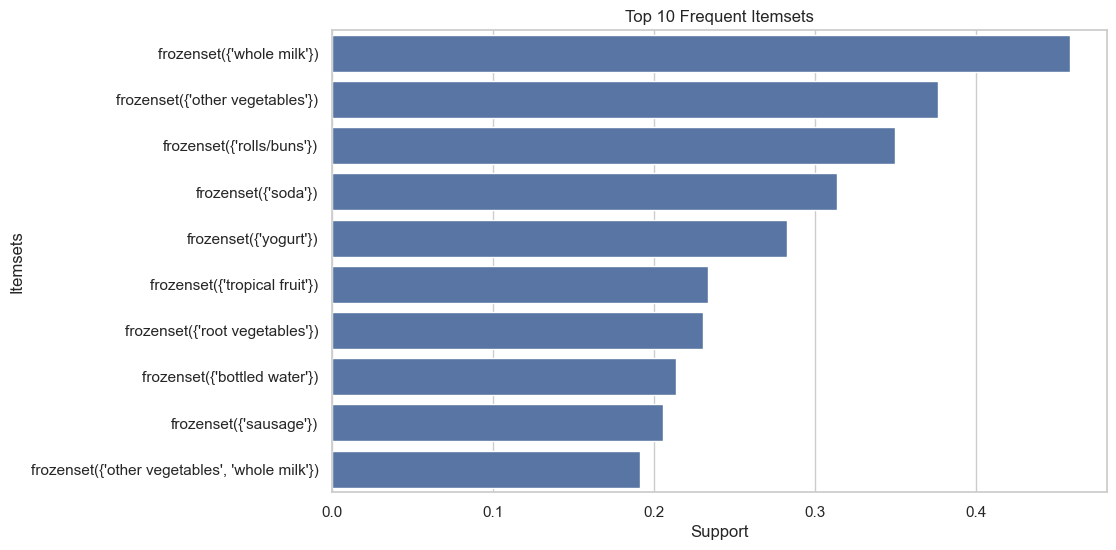

In [42]:
# Visualizing Frequent Itemsets
top_itemsets = frequent_itemsets_apriori.sort_values(by='support', ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x='support', y=top_itemsets['itemsets'].astype(str), data=top_itemsets)
plt.title('Top 10 Frequent Itemsets')
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.show()

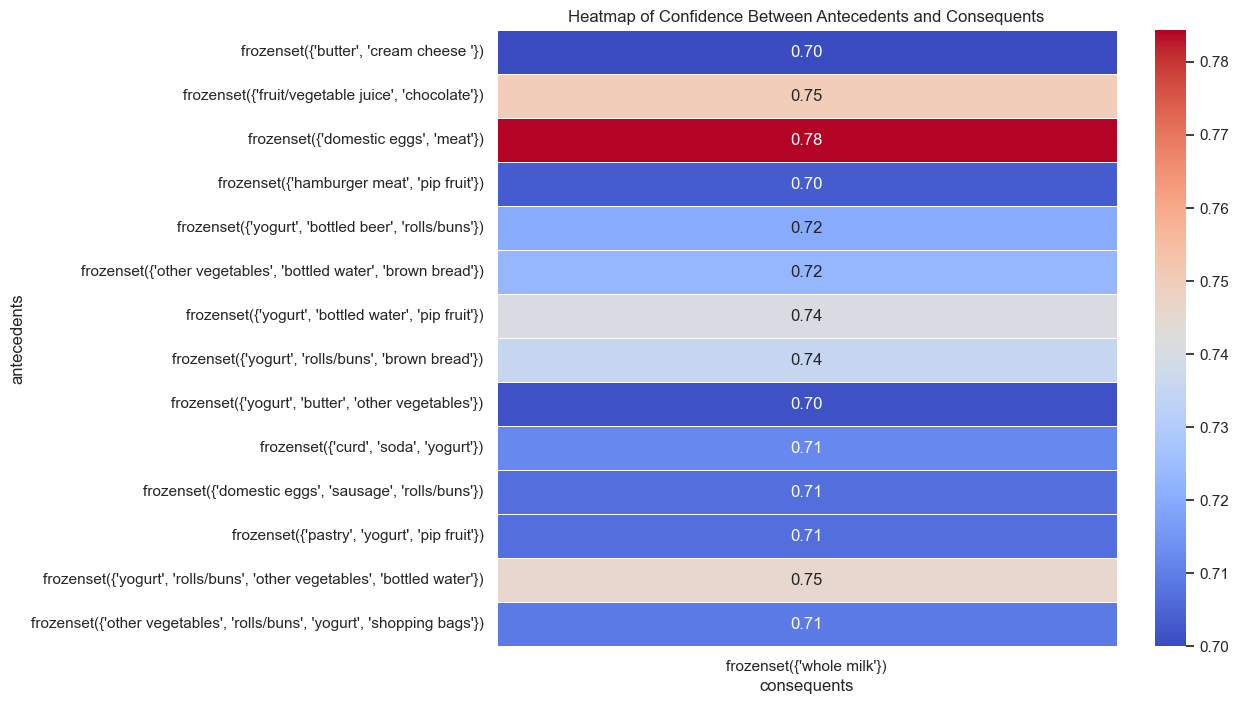

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming rules_apriori is defined from the previous code
if 'rules_apriori' in locals() and not rules_apriori.empty:
    # Filter the rules to keep only those with high confidence and lift
    filtered_rules = rules_apriori[(rules_apriori['confidence'] >= 0.7) & (rules_apriori['lift'] >= 1.5)]

    # Pivot the filtered rules for heatmap visualization
    pivot = filtered_rules.pivot(index='antecedents', columns='consequents', values='confidence')

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title("Heatmap of Confidence Between Antecedents and Consequents")
    plt.show()
else:
    print("No association rules found to visualize.")

In [43]:
# Generate frequent itemsets using fpgrowth
frequent_itemsets_fpgrowth = fpgrowth(df, min_support=0.01, use_colnames=True)

In [44]:
# Generate association rules from the frequent itemsets
rules_fpgrowth = association_rules(frequent_itemsets_apriori,'Member_number',metric="confidence", min_threshold=0.5)

# Display the generated rules
print("fpgrowth Association Rules:")
print(rules_fpgrowth[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

fpgrowth Association Rules:
                                            antecedents         consequents  \
0                                            (UHT-milk)        (whole milk)   
1                                                (beef)        (whole milk)   
2                                        (bottled beer)        (whole milk)   
3                                       (bottled water)        (whole milk)   
4                                         (brown bread)        (whole milk)   
...                                                 ...                 ...   
1112  (other vegetables, rolls/buns, yogurt, shoppin...        (whole milk)   
1113  (other vegetables, shopping bags, yogurt, whol...        (rolls/buns)   
1114    (yogurt, rolls/buns, shopping bags, whole milk)  (other vegetables)   
1115       (yogurt, soda, rolls/buns, other vegetables)        (whole milk)   
1116             (yogurt, soda, rolls/buns, whole milk)  (other vegetables)   

       support  confide

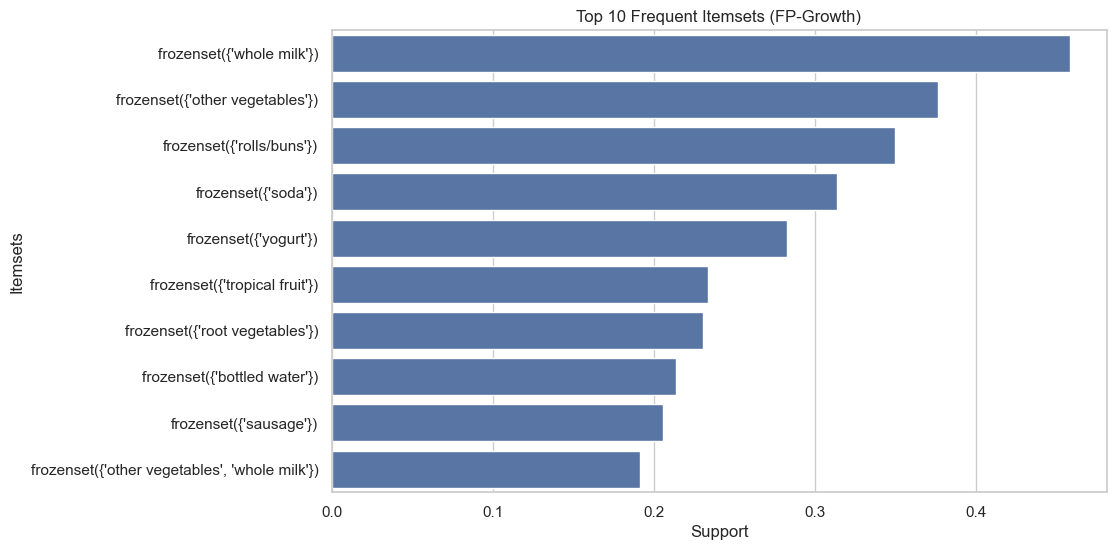

In [45]:
# Visualizing FP-Growth Frequent Itemsets
top_itemsets_fpgrowth = frequent_itemsets_fpgrowth.sort_values(by='support', ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x='support', y=top_itemsets_fpgrowth['itemsets'].astype(str), data=top_itemsets_fpgrowth)
plt.title('Top 10 Frequent Itemsets (FP-Growth)')
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.show()

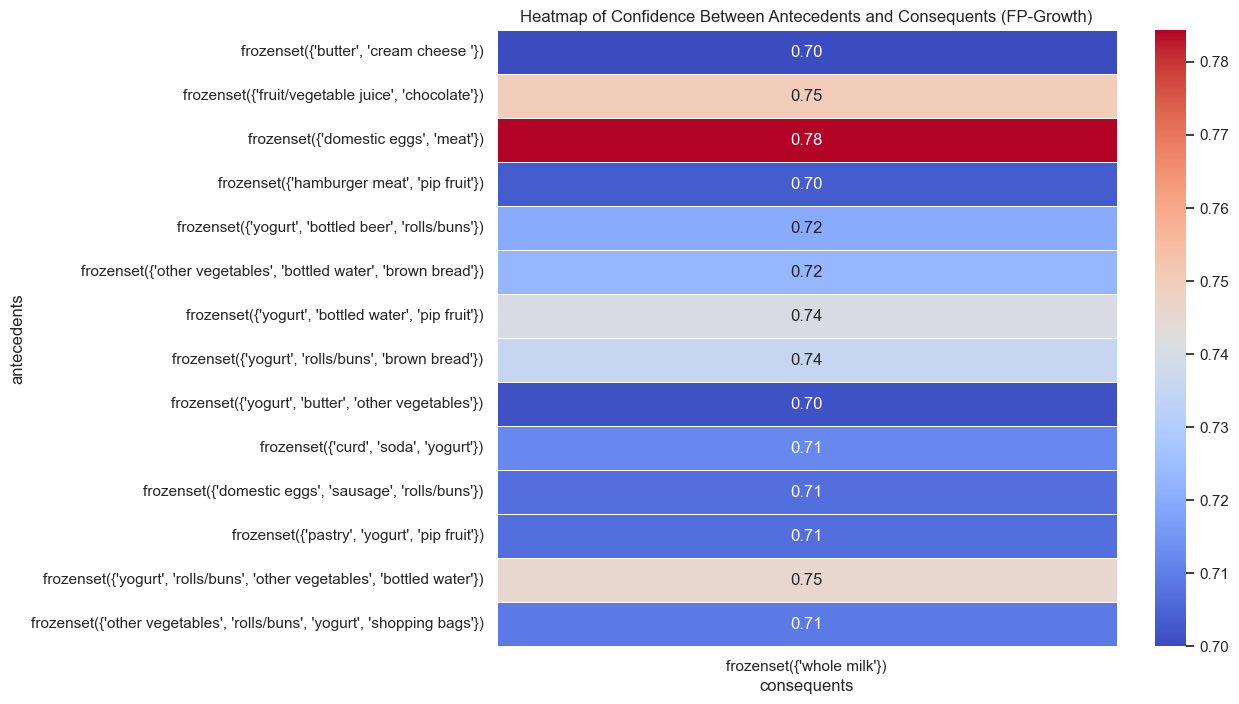

In [104]:
# Filter the FP-Growth rules to keep only those with high confidence and lift
filtered_rules_fpgrowth = rules_fpgrowth[(rules_fpgrowth['confidence'] >= 0.7) & (rules_fpgrowth['lift'] >= 1.5)]

# Pivot the filtered rules for heatmap visualization
pivot_fpgrowth = filtered_rules_fpgrowth.pivot(index='antecedents', columns='consequents', values='confidence')

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_fpgrowth, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap of Confidence Between Antecedents and Consequents (FP-Growth)")
plt.show()

In [ ]:
The below code analyzes customer transactions to find associations between products and segments transactions into clusters based on purchasing behavior, providing insights into customer preferences and product relationships

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


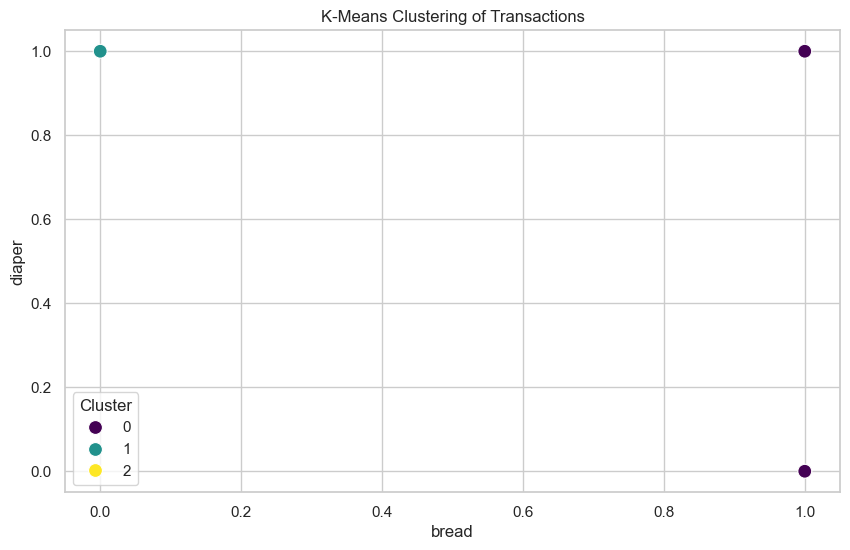

Cluster Summary:
         bread  diaper  milk
Cluster                     
0          1.0     0.5   0.0
1          0.5     1.0   1.0
2          1.0     0.0   1.0


In [126]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Sample transactions for demonstration
transactions = [['milk', 'bread'], ['bread'], ['milk', 'diaper'], ['milk', 'bread', 'diaper'], ['bread', 'diaper']]

# Transform the transaction data for analysis using TransactionEncoder
te = TransactionEncoder()
te_data = te.fit(transactions).transform(transactions)
df_onehot = pd.DataFrame(te_data, columns=te.columns_)

# Generate frequent itemsets using Apriori
frequent_itemsets_apriori = apriori(df_onehot, min_support=0.01, use_colnames=True)

# Generate association rules from the frequent itemsets
rules_apriori = association_rules(frequent_itemsets_apriori, 'Member_numer', metric="confidence", min_threshold=0.5)

# K-Means Clustering
# Step 1: Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_onehot)

# Step 2: Apply K-Means Clustering
k = 3  
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(df_scaled)

# Step 3: Add cluster labels to the original DataFrame
df_onehot['Cluster'] = clusters

# Step 4: Visualize the clusters
col1 = df_onehot.columns[0]  # First column
col2 = df_onehot.columns[1]  # Second column

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_onehot, x=col1, y=col2, hue='Cluster', palette='viridis', s=100)
plt.title("K-Means Clustering of Transactions")
plt.xlabel(col1)
plt.ylabel(col2)
plt.legend(title='Cluster')
plt.show()

# Step 5: Analyze the clusters
cluster_summary = df_onehot.groupby('Cluster').mean()
print("Cluster Summary:")
print(cluster_summary)

In [ ]:
Analysis:
The plot suggests that customers who buy a lot of bread tend not to buy diapers, while customers who buy diapers often buy a smaller amount of bread. This is likely due to the types of households associated with the buying patterns.
The plot doesn't provide any information about the number of transactions in each cluster.
This plot could be used to improve targeting for marketing campaigns. For example, a supermarket could offer discounts on diapers to customers in Cluster 1 to encourage them to buy more bread. Similarly, they could offer discounts on bread to customers in Cluster 0.

In [ ]:
#SECOND DATASET

In [89]:
# Load the second dataset for Time-Based Analysis and Customer Segmentation
data = pd.read_excel('C:/Users/ZTall/OneDrive/onlineretail.xlsx')

In [90]:
# Remove unnamed columns
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

In [91]:
data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
40642,539739,22845,VINTAGE CREAM CAT FOOD CONTAINER,1,2010-12-21 15:19:00,12.72,NaN,United Kingdom
40643,539739,22873,NUMBER TILE COTTAGE GARDEN 5,1,2010-12-21 15:19:00,4.21,NaN,United Kingdom
40644,539739,22893,MINI CAKE STAND T-LIGHT HOLDER,1,2010-12-21 15:19:00,0.85,NaN,United Kingdom
40645,539739,22896,PEG BAG APPLES DESIGN,1,2010-12-21 15:19:00,5.06,NaN,United Kingdom


In [58]:
# Convert 'InvoiceDate' to datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [59]:
# Add a new column for Total Sales (Quantity * Price)
data['TotalSales'] = data['Quantity'] * data['Price']

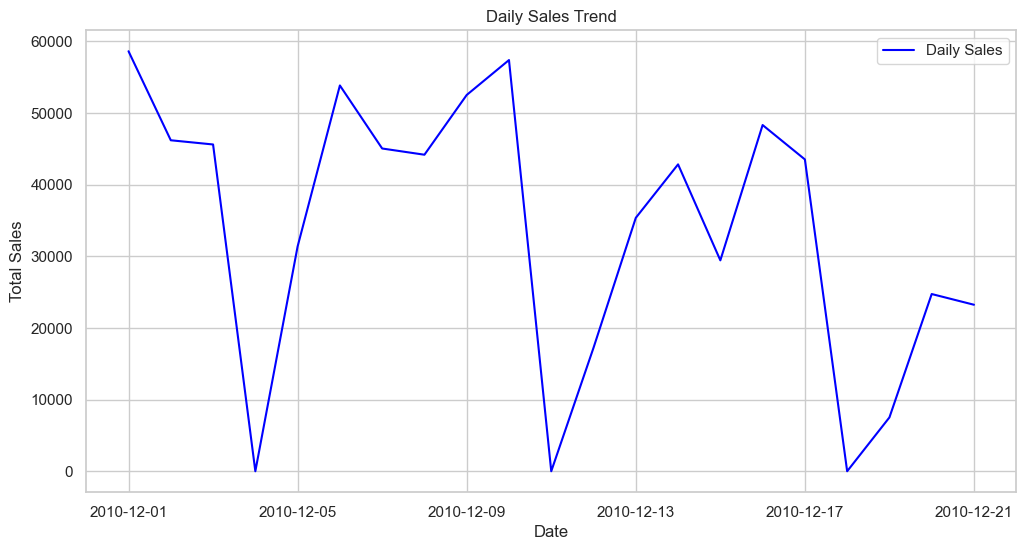

In [62]:
# Daily Sales Trend
daily_sales = data.resample('D', on='InvoiceDate')['TotalSales'].sum()
plt.figure(figsize=(12, 6))
plt.plot(daily_sales, color='blue', label='Daily Sales')
plt.title('Daily Sales Trend')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

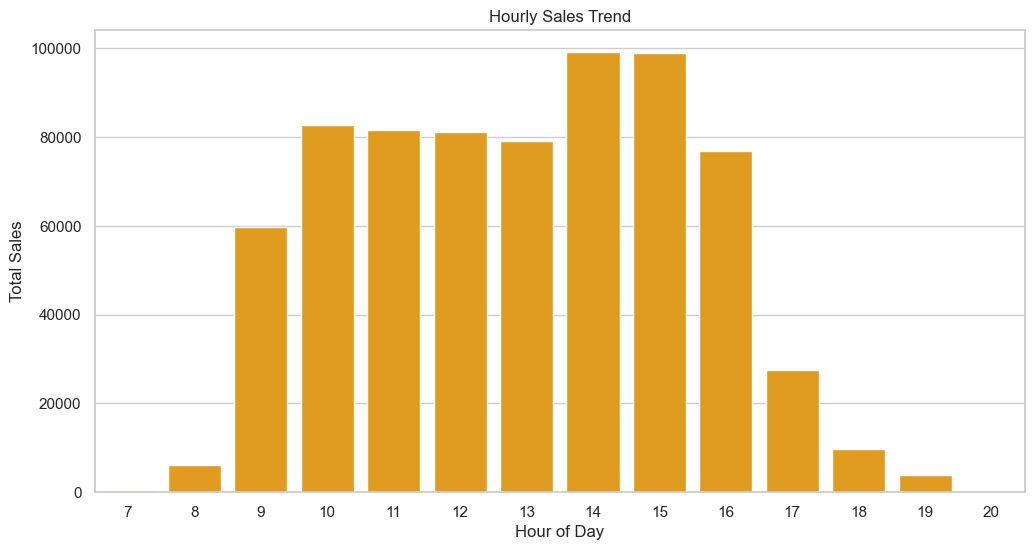

In [63]:
# Hourly Sales Analysis
data['Hour'] = data['InvoiceDate'].dt.hour
hourly_sales = data.groupby('Hour')['TotalSales'].sum()
plt.figure(figsize=(12, 6))
sns.barplot(x=hourly_sales.index, y=hourly_sales.values, color='orange')
plt.title('Hourly Sales Trend')
plt.xlabel('Hour of Day')
plt.ylabel('Total Sales')
plt.show()

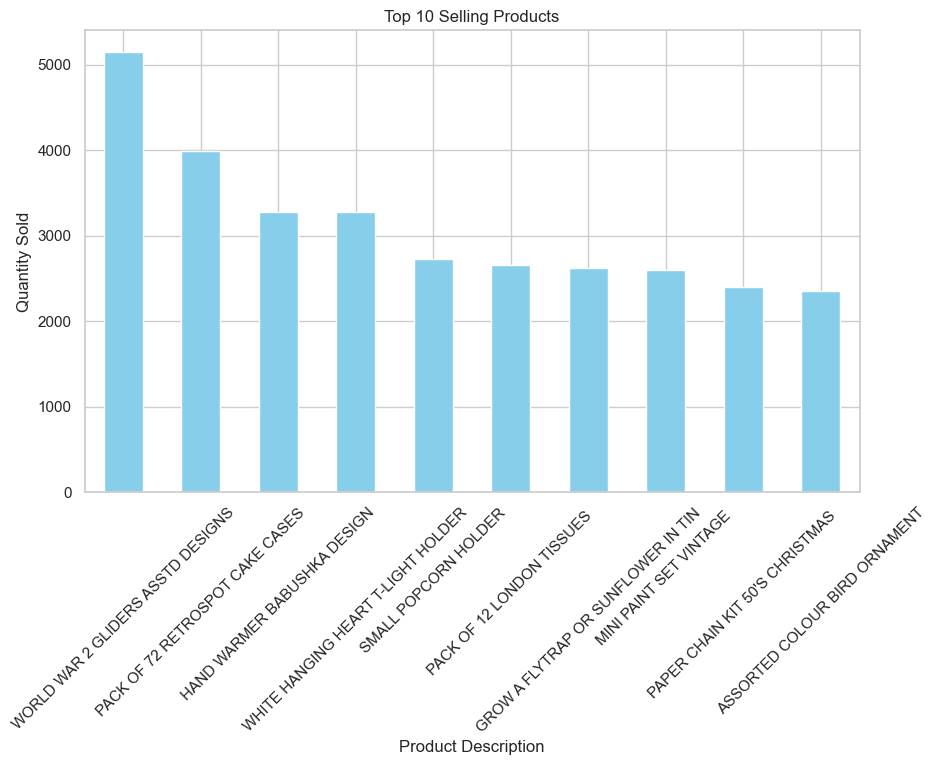

Error: 'Country' or 'Quantity' column not found in the DataFrame.


In [94]:
top_products = data.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_products.plot(kind='bar', color='skyblue')
plt.title('Top 10 Selling Products')
plt.xlabel('Product Description')
plt.ylabel('Quantity Sold')
plt.xticks(rotation=45)
plt.show()# Check if 'Country' and 'Quantity' columns exist in the DataFrame
if 'Country' in df.columns and 'Quantity' in df.columns:
    # Group by 'Country' and sum the 'Quantity'
    country_sales = df.groupby('Country')['Quantity'].sum().sort_values(ascending=False)
    
    # Plotting
    plt.figure(figsize=(10, 8))
    country_sales.plot(kind='bar', color='lightgreen')
    plt.title('Sales Quantity by Country')
    plt.xlabel('Country')
    plt.ylabel('Quantity Sold')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("Error: 'Country' or 'Quantity' column not found in the DataFrame.")

In [96]:
data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
40642,539739,22845,VINTAGE CREAM CAT FOOD CONTAINER,1,2010-12-21 15:19:00,12.72,NaN,United Kingdom
40643,539739,22873,NUMBER TILE COTTAGE GARDEN 5,1,2010-12-21 15:19:00,4.21,NaN,United Kingdom
40644,539739,22893,MINI CAKE STAND T-LIGHT HOLDER,1,2010-12-21 15:19:00,0.85,NaN,United Kingdom
40645,539739,22896,PEG BAG APPLES DESIGN,1,2010-12-21 15:19:00,5.06,NaN,United Kingdom


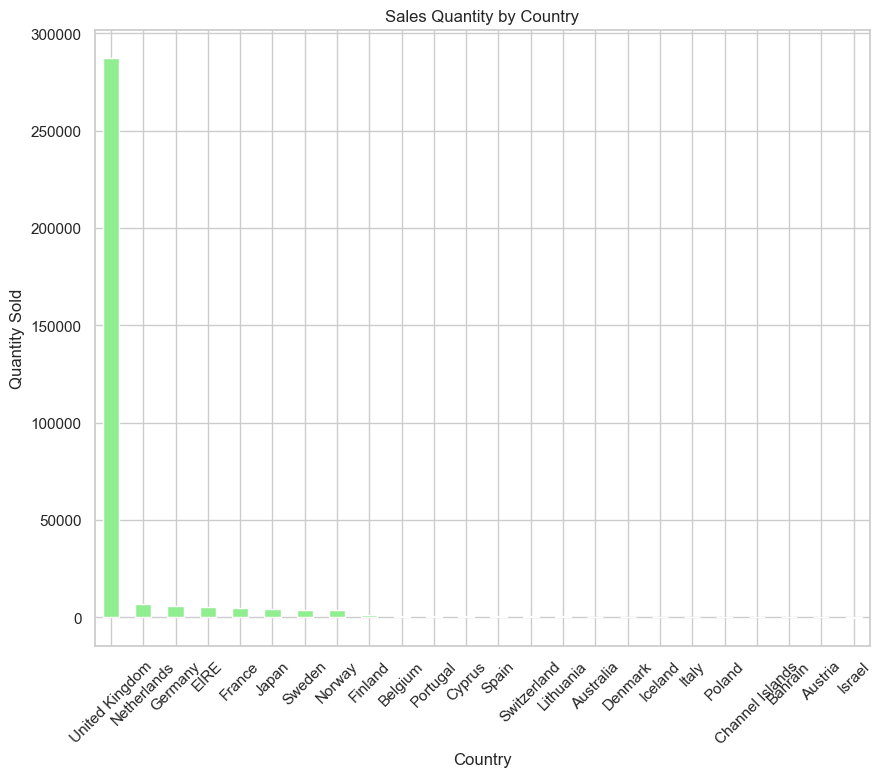

In [98]:
###Sales by Country1
country_sales = data.groupby('Country')['Quantity'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 8))
country_sales.plot(kind='bar', color='lightgreen')
plt.title('Sales Quantity by Country')
plt.xlabel('Country')
plt.ylabel('Quantity Sold')
plt.xticks(rotation=45)
plt.show()

In [ ]:
TIME SERIES ANALYSIS

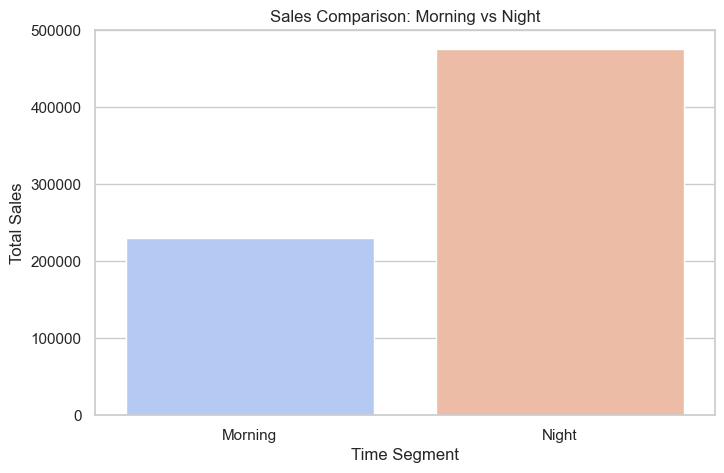

In [64]:
# Morning vs Night Analysis
data['TimeSegment'] = data['Hour'].apply(lambda x: 'Morning' if x < 12 else 'Night')
time_segment_sales = data.groupby('TimeSegment')['TotalSales'].sum()
plt.figure(figsize=(8, 5))
sns.barplot(x=time_segment_sales.index, y=time_segment_sales.values, palette='coolwarm')
plt.title('Sales Comparison: Morning vs Night')
plt.xlabel('Time Segment')
plt.ylabel('Total Sales')
plt.show()

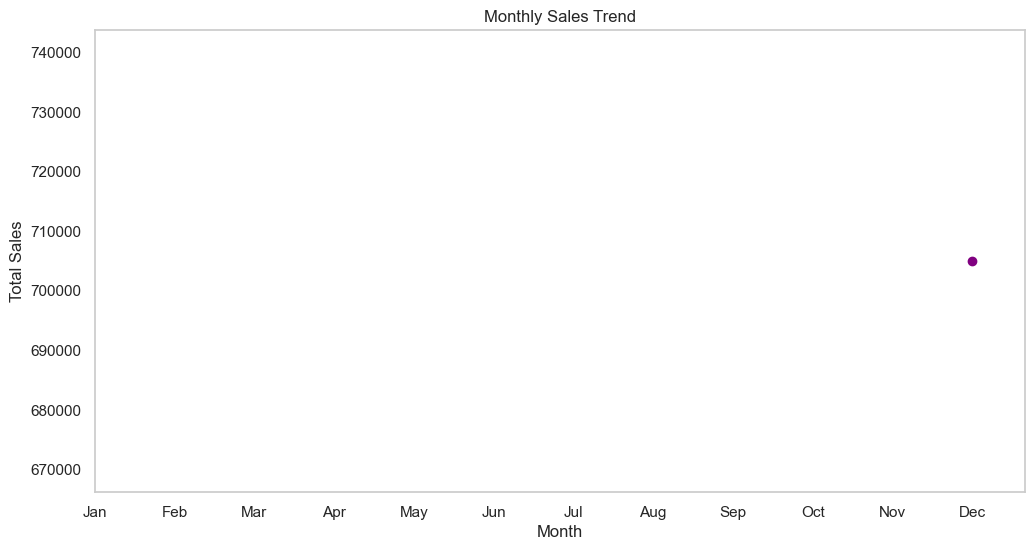

In [81]:
#Seasonality Analysis ( code is analyzing and visualizing the trend of total sales over the months of the year, such as peaks or troughs in specific months)
#Extract month from InvoiceDate
data['Month'] = data['InvoiceDate'].dt.month
monthly_sales = data.groupby('Month')['TotalSales'].sum()

plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='line', marker='o', color='purple')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(ticks=np.arange(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid()
plt.show()

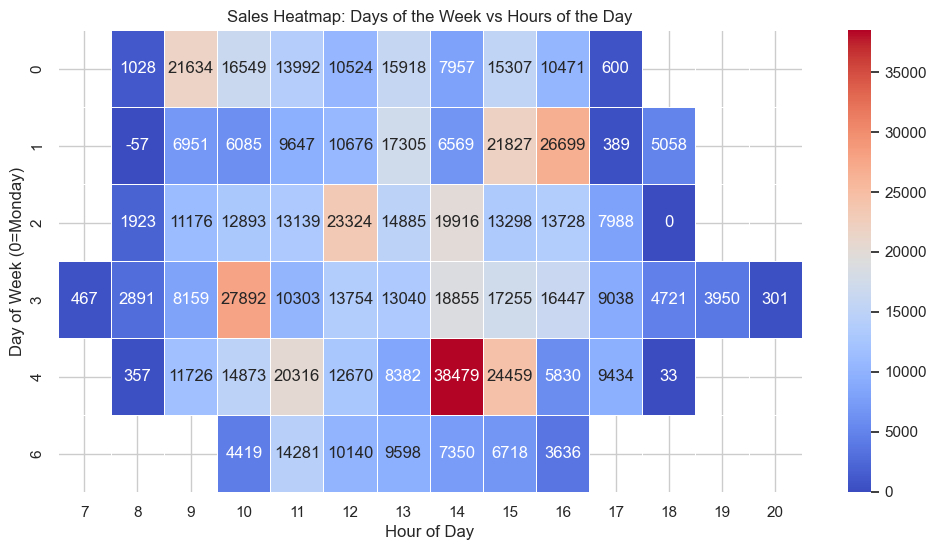

In [65]:
#Heatmap of Hourly Sales Across Days of the Week
data['DayOfWeek'] = data['InvoiceDate'].dt.dayofweek  # Monday=0, Sunday=6
heatmap_data = data.pivot_table(values='TotalSales', index='DayOfWeek', columns='Hour', aggfunc='sum')
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".0f", linewidths=0.5)
plt.title("Sales Heatmap: Days of the Week vs Hours of the Day")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week (0=Monday)")
plt.show()

In [66]:
# Data Cleaning for Customer Segmentation
data['Customer ID'].fillna(0, inplace=True)
data.dropna(subset=['Description'], inplace=True)
data.loc[data['Quantity'] < 0, 'Quantity'] = 0
data.loc[data['Price'] < 0, 'Price'] = 0
data.drop_duplicates(inplace=True)

In [67]:
# RFM Analysis
data['TotalPrice'] = data['Quantity'] * data['Price']
snapshot_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = data.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Invoice': 'count',  # Frequency
    'TotalPrice': 'sum'  # Monetary
}).reset_index()
rfm.rename(columns={'InvoiceDate': 'Recency', 'Invoice': 'Frequency', 'TotalPrice': 'Monetary'}, inplace=True)


In [68]:
# RFM Scoring
def rfm_score(x, p):
    if x <= p[0.25]:
        return 1
    elif x <= p[0.50]:
        return 2
    elif x <= p[0.75]:
        return 3
    else:
        return 4

quantiles = rfm.quantile(q=[0.25, 0.5, 0.75])
rfm['R_Score'] = rfm['Recency'].apply(rfm_score, args=(quantiles['Recency'],))
rfm['F_Score'] = rfm['Frequency'].apply(rfm_score, args=(quantiles['Frequency'],))
rfm['M_Score'] = rfm['Monetary'].apply(rfm_score, args=(quantiles['Monetary'],))
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

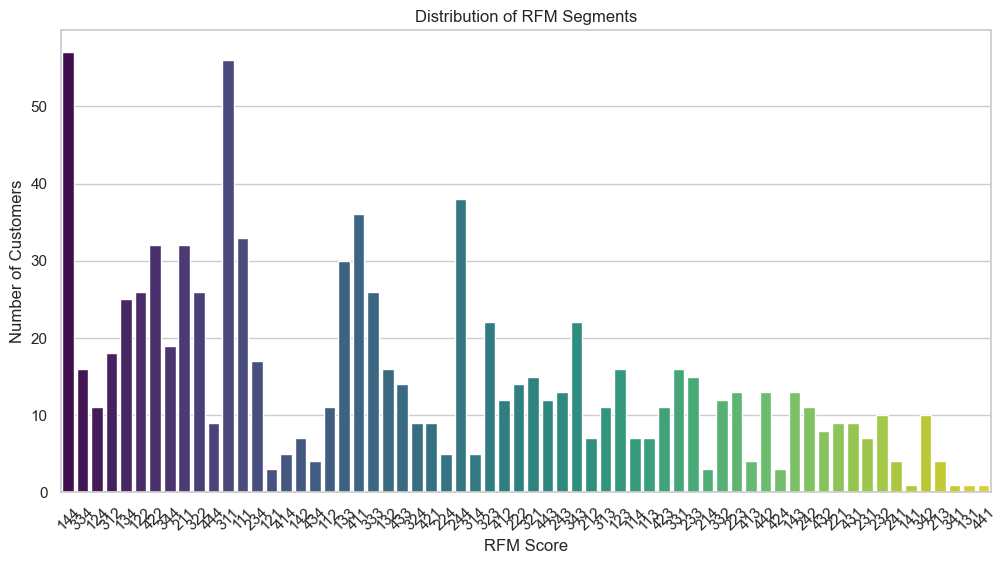

In [69]:
# Distribution of RFM Scores
plt.figure(figsize=(12, 6))
sns.countplot(data=rfm, x='RFM_Score', palette='viridis')
plt.title('Distribution of RFM Segments')
plt.xlabel('RFM Score')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()

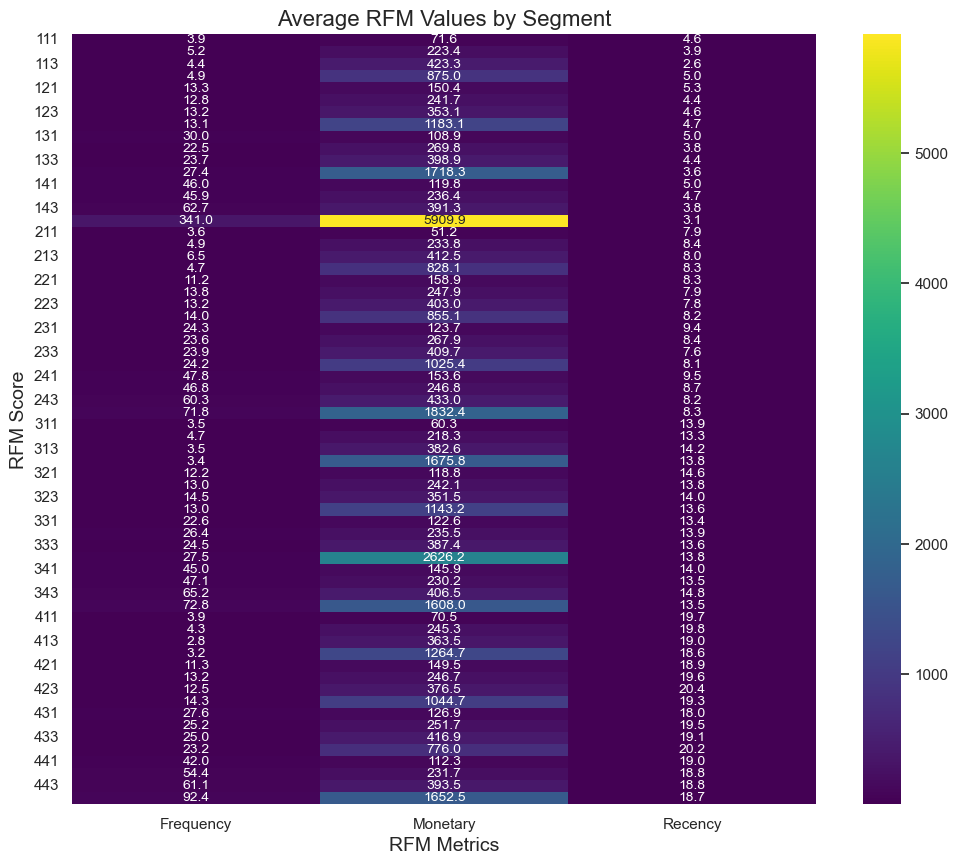

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a pivot table for heatmap
heatmap_data = rfm.pivot_table(index='RFM_Score', values=['Recency', 'Frequency', 'Monetary'], aggfunc='mean')

# Plot heatmap with improved clarity
plt.figure(figsize=(12, 10), dpi=100)  # Increase figure size and DPI
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt=".1f", annot_kws={"size": 10})  # Change colormap and increase annotation size
plt.title('Average RFM Values by Segment', fontsize=16)
plt.xlabel('RFM Metrics', fontsize=14)
plt.ylabel('RFM Score', fontsize=14)
plt.show()

In [100]:
# Analyze average RFM values for each segment
segment_analysis = rfm.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Customer ID': 'count'
}).reset_index()

segment_analysis.rename(columns={'Customer ID': 'Customer Count'}, inplace=True)

print(segment_analysis)

   RFM_Score    Recency  Frequency     Monetary  Customer Count
0        111   4.606061   3.939394    71.573636              33
1        112   3.909091   5.181818   223.381818              11
2        113   2.571429   4.428571   423.312857               7
3        114   5.000000   4.857143   874.951429               7
4        121   5.333333  13.333333   150.426667               3
..       ...        ...        ...          ...             ...
59       434  20.250000  23.250000   776.027500               4
60       441  19.000000  42.000000   112.270000               1
61       442  18.846154  54.384615   231.652308              13
62       443  18.833333  61.083333   393.454167              12
63       444  18.666667  92.444444  1652.506667               9

[64 rows x 5 columns]


In [ ]:
Each profile will show the details of customers who fall into that specific RFM score category, allowing for a better understanding of customer behavior and segmentation.
Usefulness:
This profiling can be particularly useful for:

Targeted Marketing: Tailoring marketing strategies to specific customer segments based on their purchasing behavior.
Customer Retention: Identifying high-value customers and developing strategies to retain them.
Resource Allocation: Allocating marketing resources more effectively by focusing on segments that are more likely to respond positively.

In [101]:
# Create customer profiles
for score in segment_analysis['RFM_Score']:
    profile = segment_analysis[segment_analysis['RFM_Score'] == score]
    print(f"Profile for RFM Score {score}:")
    print(profile)
    print("\n")

Profile for RFM Score 111:
  RFM_Score   Recency  Frequency   Monetary  Customer Count
0       111  4.606061   3.939394  71.573636              33


Profile for RFM Score 112:
  RFM_Score   Recency  Frequency    Monetary  Customer Count
1       112  3.909091   5.181818  223.381818              11


Profile for RFM Score 113:
  RFM_Score   Recency  Frequency    Monetary  Customer Count
2       113  2.571429   4.428571  423.312857               7


Profile for RFM Score 114:
  RFM_Score  Recency  Frequency    Monetary  Customer Count
3       114      5.0   4.857143  874.951429               7


Profile for RFM Score 121:
  RFM_Score   Recency  Frequency    Monetary  Customer Count
4       121  5.333333  13.333333  150.426667               3


Profile for RFM Score 122:
  RFM_Score   Recency  Frequency    Monetary  Customer Count
5       122  4.384615  12.846154  241.679615              26


Profile for RFM Score 123:
  RFM_Score  Recency  Frequency    Monetary  Customer Count
6       123

In [102]:
# Save the RFM DataFrame to a CSV file
rfm.to_csv('customer_rfm_segments.csv', index=False)

In [70]:
# K-Means Clustering
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

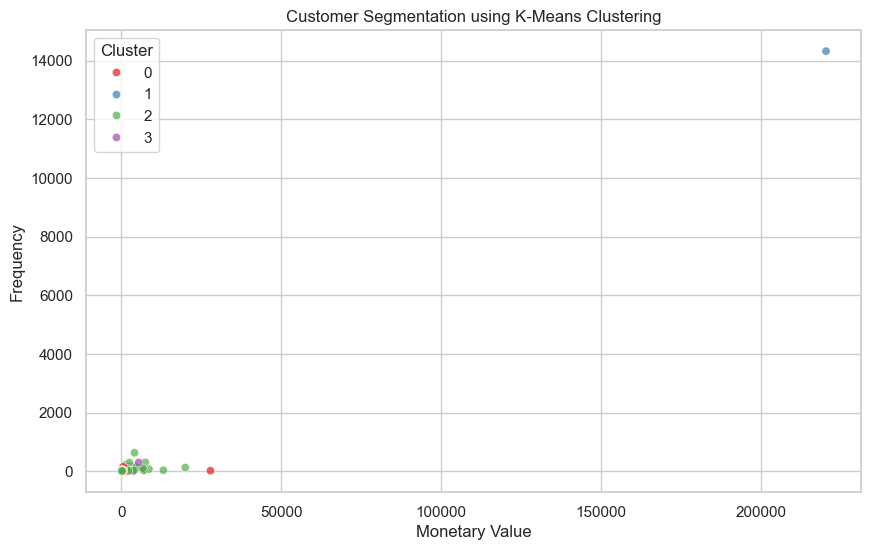

In [71]:
# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Monetary', y='Frequency', hue='Cluster', palette='Set1', alpha=0.7)
plt.title('Customer Segmentation using K-Means Clustering')
plt.xlabel('Monetary Value')
plt.ylabel('Frequency')
plt.legend(title='Cluster')
plt.show()

In [72]:
# Decision Tree for Customer Segmentation
X = rfm[['Recency', 'Frequency', 'Monetary']]
y = rfm['Cluster']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [73]:
# Feature importance
importance = dtree.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

In [74]:
# Display feature importance
print(feature_importance)

     Feature  Importance
0    Recency    0.995416
2   Monetary    0.004584
1  Frequency    0.000000


In [75]:
# Calculate Customer Lifetime Value (CLV)
rfm['CLV'] = rfm['Monetary'] * rfm['Frequency']  # Simplified CLV calculation
print("Customer Lifetime Value (CLV):")
print(rfm[['Customer ID', 'CLV']].head())

Customer Lifetime Value (CLV):
   Customer ID           CLV
0          0.0  3.155465e+09
1      12347.0  2.206549e+04
2      12348.0  1.517760e+04
3      12370.0  1.677843e+05
4      12377.0  4.306536e+04


In [76]:
# Define churned customers (e.g., no purchase in the last 30 days)
churn_threshold = 30
rfm['Churned'] = rfm['Recency'] > churn_threshold
print("Churned Customers:")
print(rfm[rfm['Churned'] == True].head())

Churned Customers:
Empty DataFrame
Columns: [Customer ID, Recency, Frequency, Monetary, R_Score, F_Score, M_Score, RFM_Score, Cluster, CLV, Churned]
Index: []


In [ ]:
###Customer Segmentation with PCA
Use Principal Component Analysis (PCA) to reduce dimensionality and visualize customer segments.

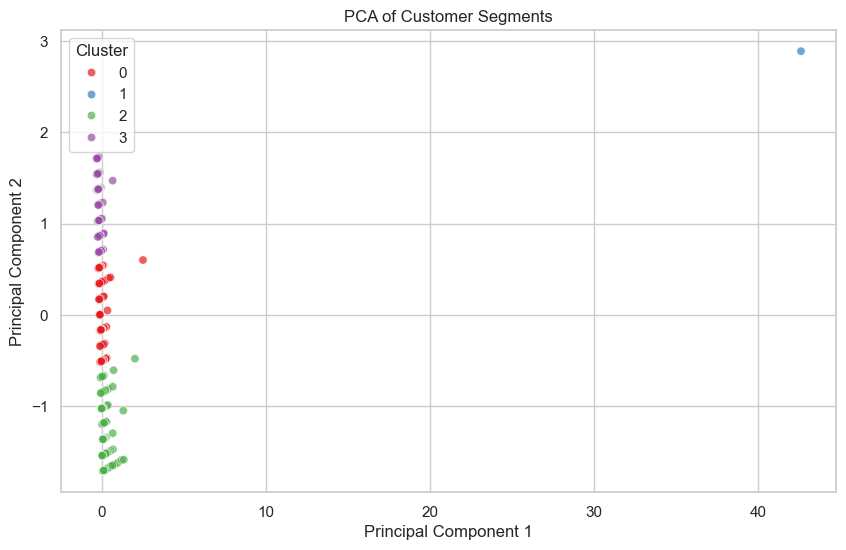

In [83]:
from sklearn.decomposition import PCA

# Standardize the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(rfm_scaled)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = rfm['Cluster']

# Plot PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='Set1', alpha=0.7)
plt.title('PCA of Customer Segments')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()